In [56]:
from hdrh.histogram import HdrHistogram
import seaborn as sns
import pandas
from matplotlib import pyplot as plt
import os.path
import matplotlib as mpl
from typing import *


MIN_LATENCY_USEC = 1
MAX_LATENCY_USEC = 1000*1000 # 1 sec
LATENCY_SIGNIFICANT_DIGITS = 5

BENCHS = {
    'lusearch': 'lusearch.3023.70',
    'cassandra': 'cassandra.3023.269',
    'h2': 'h2.3023.3489',
    'tomcat': 'tomcat.3023.76',
}

log = lambda runid, buildstring: f'/home/wenyuz/MMTk-Dev/evaluation/results/log/{runid}/{buildstring}'

# Phase time curve

In [57]:
MIN_PAUSE_USEC = 1
MAX_PAUSE_USEC = 1000*1000 # 1 sec
PAUSE_SIGNIFICANT_DIGITS = 5

def load_phase_time_data(invocation, folder):
    path = "{}.{}/pauses.csv".format(folder, invocation)
    if not os.path.isfile(path):
        return None
    names = ['total', 'wait', 'init', 'prepare', 'closure', 'refclosure', 'refforwarding', 'release', 'final']
    df = pandas.read_csv(path, names=names)
    for name in names:
        df[name] = df[name] / 1000
    return df

def plot_phase_data(bench, title, phase, data: Dict[str, Union[str, List[str]]], invocations = 10, save = None, ax = None, labelSize = 26, tickSize = 20):
    # print('Loading...')
    folders_dict = data
    gcs = list(folders_dict.keys())
    histograms = {}
    for gc in gcs:
        histograms[gc] = []
        for i in range(invocations):
            folders = folders_dict[gc] if isinstance(folders_dict[gc], list) else [folders_dict[gc]]
            for folder in folders:
                histogram = HdrHistogram(MIN_PAUSE_USEC, MAX_PAUSE_USEC, PAUSE_SIGNIFICANT_DIGITS)
                data = load_phase_time_data(i, folder)
                if data is None:
                    continue
                latencies = data[phase]
                for l in latencies:
                    histogram.record_value(l)
                histograms[gc].append(histogram)
    
    # print('Processing...')
    percentile_list = []
    for gc, hists in histograms.items():
        for j, histogram in enumerate(hists):
            for i in histogram.get_percentile_iterator(5):
                x = i.percentile_level_iterated_to
                percentile_list.append({"GC": gc, "inv": j, "value": i.value_iterated_to, "percentile": i.percentile_level_iterated_to / 100})
    percentile_df = pandas.DataFrame(percentile_list)
    percentile_df["other"] = 1 / (1 - percentile_df["percentile"])

    # print('Plotting...')
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(16,12))
        # fig.suptitle(title, fontsize=26)
    ax.title.set_text(title)
    sns.color_palette()
    colors = ['green', 'blue', 'orange', 'red'][:len(gcs)]
    # print(f'{gcs} {colors}')
    sns.lineplot(data=percentile_df, x="other", y="value", hue="GC", palette=colors, ax=ax)
    # sns.lineplot(data=percentile_df, x="other", y="value", hue="GC")
    ax.set_xscale('log')
    ax.set_xlabel('', fontsize=labelSize, labelpad=12)
    ax.set_ylabel('Time (msec)', fontsize=labelSize, labelpad=12)
    ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_xticklabels(['0', '90', '99', '99.9', '99.99', '99.999', '99.9999'], fontsize=tickSize)
    plt.yticks(fontsize=tickSize)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{x / 1000:.3f}'.format(x)))
    # plt.legend(fontsize=16)

    if save is not None:
        plt.savefig(save, bbox_inches='tight')


def plot_phases(bench, data: Union[str, List[str]], invocations=20):
    fig, ax = plt.subplots(2, 3, figsize=(20,10))
    def _plot_phase(ax, phase, title):
        plot_phase_data(
            bench = bench,
            phase = phase,
            title = title,
            data = { 'LXR': data },
            invocations = 20,
            ax = ax,
            labelSize=None,
            tickSize=None
        )
    _plot_phase(ax[0, 0], 'total', '#0 Total')
    _plot_phase(ax[0, 1], 'wait', '#1 wait for lazy decs / sweep, mature collection set selection')
    _plot_phase(ax[0, 2], 'init', '#2 Roots, Incs, Mark-table zeroing')
    _plot_phase(ax[1, 0], 'prepare', '#3 Prepare')
    _plot_phase(ax[1, 1], 'closure', '#4 Mature evac, STW marking, SATB ModBuf')
    _plot_phase(ax[1, 2], 'release', '#5 Release')

## lusearch

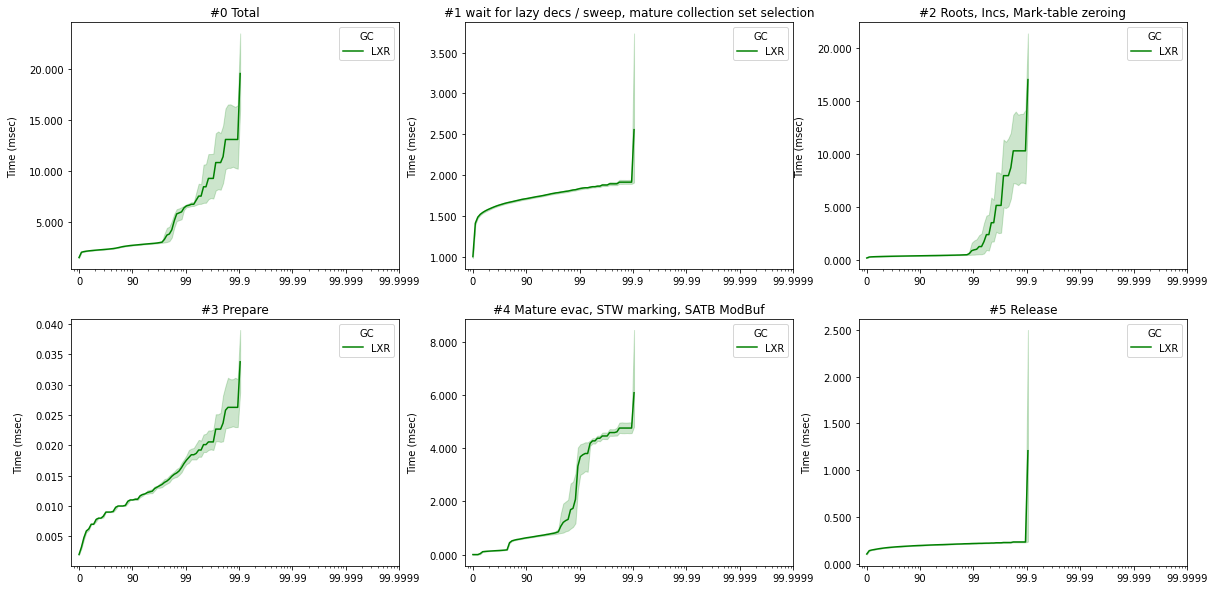

In [58]:
BENCH = 'lusearch'

runid1 = 'elk-2021-12-05-Sun-154101'

plot_phases(BENCH, log(runid1, f'{BENCHS[BENCH]}.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'))

## cassandra

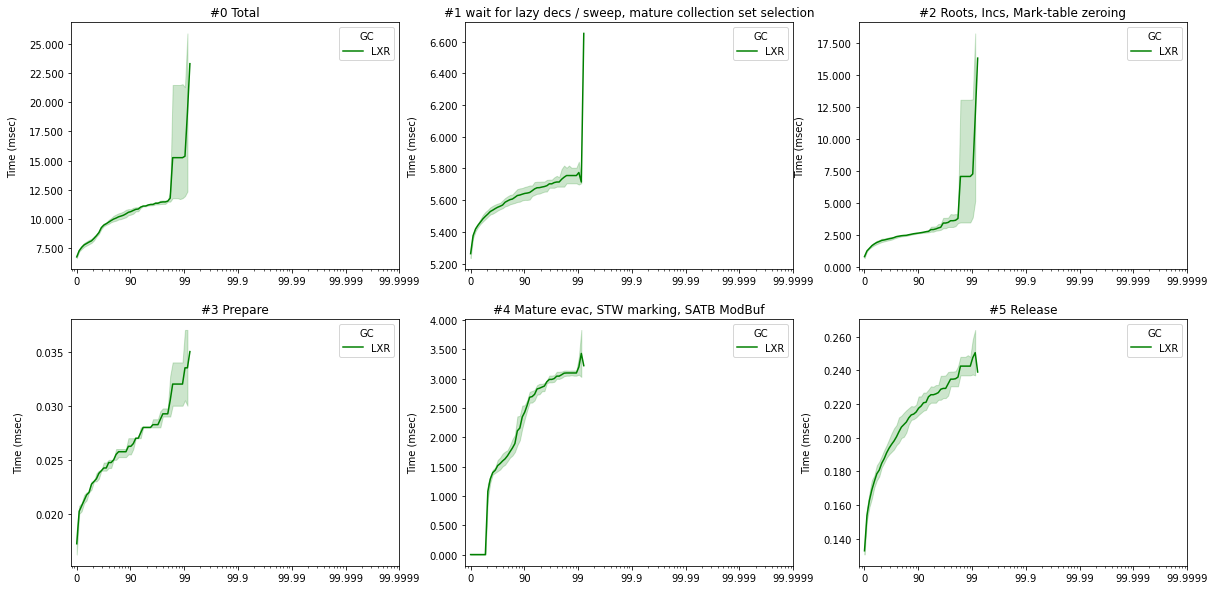

In [59]:
BENCH = 'cassandra'

runid1 = 'elk-2021-12-05-Sun-154101'

plot_phases(BENCH, log(runid1, f'{BENCHS[BENCH]}.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'))

## h2

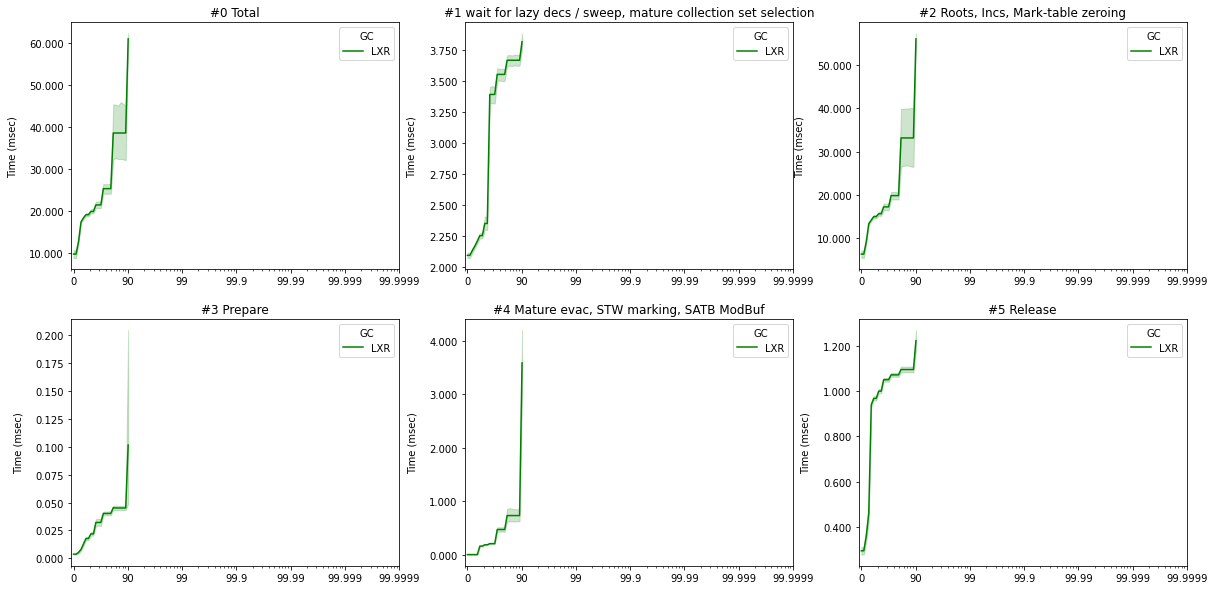

In [60]:
BENCH = 'h2'

runid1 = 'elk-2021-12-05-Sun-154101'

plot_phases(BENCH, log(runid1, f'{BENCHS[BENCH]}.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'))

## tomcat

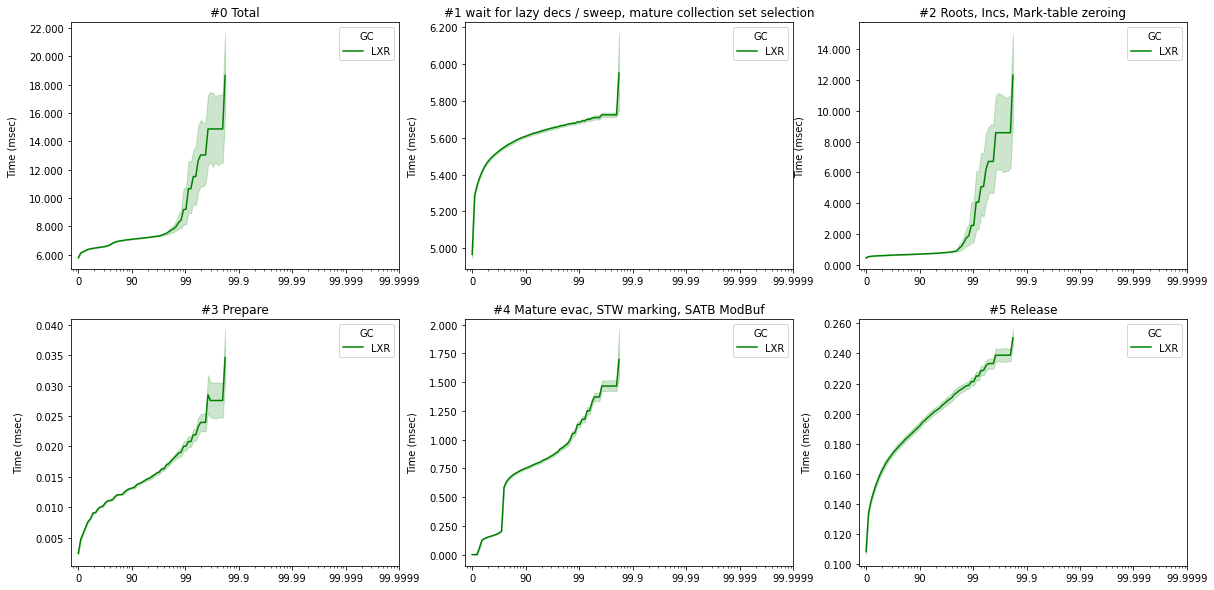

In [62]:
BENCH = 'tomcat'

runid1 = 'elk-2021-12-05-Sun-154101'

plot_phases(BENCH, log(runid1, f'{BENCHS[BENCH]}.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'))